In [1]:
## A. Write a program to fit a single hidden layer neural network (ten hidden units) 
## via back-propagation and weight decay.

In [2]:
import numpy as np
from numpy.random import multivariate_normal as GaussianRV
from numpy.random import normal 

# NN architecture 
# no. of hidden units 
no_layers=10
# no. of features
no_features=2
# parameters (including bias units)
# rule of thumb (fan-in): varianza ugual a 1/sqrt(numero nodi)
alpha=normal(loc=0.,scale=0.001,size=(1+no_features,no_layers))
beta=normal(loc=0.,scale=0.001,size=1+no_layers)
# learning rate 
gamma=0.075
# tuning parameter
rho=0.

# backprop algorithm
def sigma(v):
    return 1./(1.+np.exp(-v))
def dersigma(v):
    return np.exp(-v)/np.power(1.+np.exp(-v),2.)
def fwd_pass(x, a, b):
    z=sigma(np.matmul(a.T,x))
    z=np.insert(z,0,1.) #add bias unit 
    return float(np.matmul(b.T,z))
def bkwd_pass(x, y, a, b, M, p):
    delta_i=-2.*(y-fwd_pass(x, a, b))
    z=sigma(np.matmul(a.T,x))
    z=np.insert(z,0,1.) #add bias unit 
    dRidbeta=delta_i*z
    S_i=delta_i*(np.multiply(dersigma(np.matmul(a.T,x)),np.delete(b,0)))
    dRidalpha=np.tile(S_i,(1+p,1))
    dRidalpha=np.multiply(np.tile(x,(M,1)).T,dRidalpha)
    return dRidbeta, dRidalpha
def trainNNmodel(x, y, a, b, M, p, no, N, g, l):
    a_updated=a
    b_updated=b
    for t in range(0,no):
        for q in range(0,N):
            d,s=bkwd_pass(x[q], y[q], a_updated, b_updated, M, p)
            a_updated=a_updated-(g/(0.75*t+1))*(s+l*2.*a_updated)
            b_updated=b_updated-(g/(0.75*t+1))*(d+l*2.*b_updated)
    return (a_updated, b_updated)


In [3]:
## B. Apply it to 100 observations from the model 
## Y = σ(a^T_1 X) + (a^T_2 X)^2 + 0.30 Z,
## where σ is the sigmoid function, Z is standard normal, X^T = (X1,X2),
## each Xj being independent standard normal, and a1 = (3, 3), a2 = (3,−3). 
## B.1 Generate a test sample of size 1000, 

In [4]:
def model(x,z,v1,v2):
    return [sigma(np.matmul(v1.T,el))+np.power(np.matmul(v2.T,el),2.)+0.3*z[indx] for (indx,el) in enumerate(x)]

# 1. generate training set 
Ntrain=100
a1, a2 = np.asarray([3,3]), np.asarray([3,-3])
X1 = normal(loc=0.,scale=1.,size=Ntrain)
X2 = normal(loc=0.,scale=1.,size=Ntrain)
Xtrain = np.column_stack((X1,X2))
Z = normal(loc=0.,scale=1.,size=Ntrain)
Ytrain=model(Xtrain,Z,a1,a2)
Xtrain = np.column_stack((np.ones(Ntrain),Xtrain))

# 2. generate training set 
Ntest=1000
X1 = normal(loc=0.,scale=1.,size=Ntest)
X2 = normal(loc=0.,scale=1.,size=Ntest)
Xtest = np.column_stack((X1,X2))
Z = normal(loc=0.,scale=1.,size=Ntest)
Ytest=model(Xtest,Z,a1,a2)
Xtest = np.column_stack((np.ones(Ntest),Xtest))


In [10]:
## B.2 and plot the training and test error curves as a function of the number of training epochs, 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# learning rate 
gamma=0.05
# tuning parameter
rho=0.

results=pd.DataFrame(columns=['no_epochs','training_error'])
predictions=pd.DataFrame(columns=['no_epochs','test_error'])
    
for no_epochs in range(1,401,8):
    # train the model
    alpha_trained, beta_trained = trainNNmodel(Xtrain, Ytrain, alpha, beta, no_layers, no_features, no_epochs, Ntrain, gamma, rho)
    # calculate training error
    df=pd.DataFrame(Xtrain).apply(lambda z: fwd_pass(z.values, alpha_trained, beta_trained),axis=1)
    df=(df-pd.Series(Ytrain)).apply(lambda z: np.abs(z))
    results=pd.concat([results,pd.DataFrame({'no_epochs': [no_epochs], 'training_error': [df.mean()]})],sort=False)
    # calculate test error 
    df=pd.DataFrame(Xtest).apply(lambda z: fwd_pass(z.values, alpha_trained, beta_trained),axis=1)
    df=(df-pd.Series(Ytest)).apply(lambda z: np.abs(z))
    predictions=pd.concat([predictions,pd.DataFrame({'no_epochs': [no_epochs], 'test_error': [df.mean()]})],sort=False)


Text(0, 0.5, 'Training/Test Error')

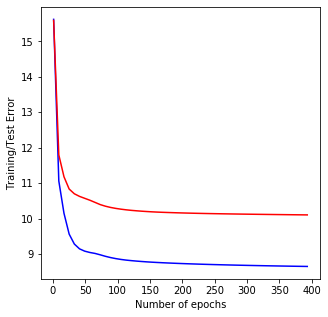

In [11]:
fig=plt.figure(figsize=(5., 5.))
plt.plot(results['no_epochs'],results['training_error'],c='blue')
plt.plot(predictions['no_epochs'],predictions['test_error'],c='red')
plt.xlabel('Number of epochs') 
plt.ylabel('Training/Test Error')

In [22]:
## B.3 for different values of the weight decay parameter. 

results=pd.DataFrame(columns=['rho','training_error'])
predictions=pd.DataFrame(columns=['rho','test_error'])
no_epochs=200
    
for rho in np.linspace(0,2,50):
    # train the model
    alpha_trained, beta_trained = trainNNmodel(Xtrain, Ytrain, alpha, beta, no_layers, no_features, no_epochs, Ntrain, gamma, rho)
    # calculate training error
    df=pd.DataFrame(Xtrain).apply(lambda z: fwd_pass(z.values, alpha_trained, beta_trained),axis=1)
    df=(df-pd.Series(Ytrain)).apply(lambda z: np.abs(z))
    results=pd.concat([results,pd.DataFrame({'rho': [rho], 'training_error': [df.mean()]})],sort=False)
    # calculate test error 
    df=pd.DataFrame(Xtest).apply(lambda z: fwd_pass(z.values, alpha_trained, beta_trained),axis=1)
    df=(df-pd.Series(Ytest)).apply(lambda z: np.abs(z))
    predictions=pd.concat([predictions,pd.DataFrame({'rho': [rho], 'test_error': [df.mean()]})],sort=False)


Text(0, 0.5, 'Training/Test Error')

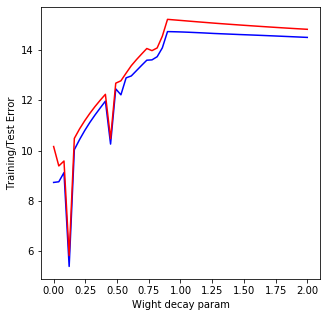

In [23]:
fig=plt.figure(figsize=(5., 5.))
plt.plot(results['rho'],results['training_error'],c='blue')
plt.plot(predictions['rho'],predictions['test_error'],c='red')
plt.xlabel('Wight decay param') 
plt.ylabel('Training/Test Error')

In [ ]:
## B.4 Discuss the overfitting behavior in each case.

In [ ]:
## C. Vary the number of hidden units in the network, from 1 up to 10, and
## determine the minimum number needed to perform well for this task.